In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import sklearn
import feature_engine as fe


In [64]:
combined = pd.read_csv("../feature_store/feature_data_milestone_1", index_col="PatientID")

In [3]:
combined.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Outcome
PatientID,,,,,,,
1017,101,58,17,265,24.2,0.614,0
1031,108,70,0,0,30.5,0.955,1
1033,148,60,27,318,30.9,0.150,1
1035,113,76,0,0,33.3,0.278,1
1048,83,86,19,0,29.3,0.317,0


In [65]:
# Determine correlations using the target variable

corrs = combined.corr(numeric_only=True)["outcome"]

In [66]:
# Use all features

X = combined[corrs.index]


In [67]:
X.head()

,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,outcome,birth_year,number_of_pregnancies,age,glucose_insulin_difference
PatientID,,,,,,,,,,,
1017,101,58,17,265,24.2,0.614,0,1998,2,26,164
1031,108,70,0,0,30.5,0.955,1,1988,8,36,108
1033,148,60,27,318,30.9,0.150,1,1992,4,32,170
1035,113,76,0,0,33.3,0.278,1,1998,0,26,113
1048,83,86,19,0,29.3,0.317,0,1987,4,37,83


In [68]:
# separate the target variable

y = combined["outcome"]

X = X.drop(columns=["outcome", "birth_year"])

In [69]:
# glucose_insulin_difference is experimental
# may need to remove this feature depending
X.describe()

,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,number_of_pregnancies,age,glucose_insulin_difference
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,120.651603,69.448980,20.634111,80.583090,31.974781,0.469886,3.819242,36.320700,92.368805
std,31.857707,19.040706,15.944848,117.712149,7.946174,0.328851,3.368724,11.884815,73.060816
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000,24.000000,0.000000
25%,99.000000,64.000000,0.000000,0.000000,27.300000,0.245250,1.000000,27.000000,35.000000
50%,117.000000,72.000000,23.000000,26.000000,32.000000,0.370500,3.000000,32.000000,92.000000
75%,140.000000,80.000000,32.000000,127.750000,36.600000,0.618000,6.000000,44.000000,124.000000
max,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,17.000000,84.000000,657.000000


In [70]:
# Split data into 80/20 train/test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=.20)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


from sklearn.pipeline import Pipeline

scaler_pipeline = Pipeline(steps=[("poly", PolynomialFeatures(degree=1))])

preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", scaler_pipeline, X.columns)
    ]
)

param_grid = [
    {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "min_samples_leaf": np.arange(1, 25, 1, dtype=int),
        "max_depth": np.arange(2, 50, 1, dtype=int)
    }
]

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)


In [72]:
grid.fit(X_train, y_train)

grid.best_estimator_

DecisionTreeClassifier(max_depth=11, min_samples_leaf=20, splitter='random')

In [73]:
# Check the raw accuracy
grid.score(X_test, y_test)

0.7028985507246377

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_predictions = grid.predict(X_test)

In [75]:
# Check the confusion matrix
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(y_test, y_predictions)

In [76]:
roc_auc_score(y_test, y_predictions)

0.6893181818181818

In [77]:
# True negatives, false positives
# False negatives, true positives

cm

array([[65, 23],
       [18, 32]])

In [78]:
cm_graphic = ConfusionMatrixDisplay(confusion_matrix=cm)

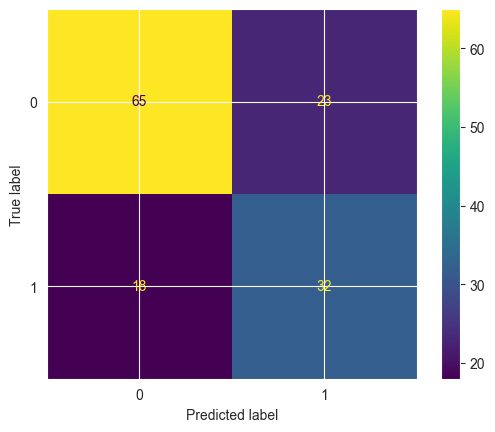

In [79]:
cm_graphic.plot()

In [80]:
from sklearn.metrics import classification_report

# Precision -accuracy of the positive predictions
# Recall - sensitivity to the true positive rate
# f1 score - weighted harmonic mean between 1 (best) 
# and 0 (worst)
# support - number of instances of class in 
# test (true) data


print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        88
           1       0.58      0.64      0.61        50

    accuracy                           0.70       138
   macro avg       0.68      0.69      0.68       138
weighted avg       0.71      0.70      0.71       138



In [81]:
# save model using joblib/pickle

import joblib


joblib.dump(grid, "../caches/logistic-regression-model-v2-trees.pkl")

['../caches/logistic-regression-model-v2-trees.pkl']